In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the N_BaIoT dataset. 
# implemented Advanced Ensemble techniques: Blending


import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import numpy as np



In [2]:
df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT_Datasets/device7.csv')

# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 115936 entries, 0 to 119999
Columns: 116 entries, MI_dir_L5_weight to label
dtypes: float64(115), int64(1)
memory usage: 103.5 MB


In [3]:

# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
4    20000
3    20000
6    20000
1    19623
5    18157
2    18156
Name: count, dtype: int64


In [4]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

start_time = time.time()

# the base models
model1 = KNeighborsClassifier()
model2 = DecisionTreeClassifier()  
model3 = LogisticRegression(solver='lbfgs', multi_class='multinomial')  
model4 = RandomForestClassifier(n_estimators=200, random_state=42)

start_train_time = time.time()
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
train_time = time.time() - start_train_time


start_pred_time = time.time()  
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
pred4 = model4.predict(X_test)
pred_time = time.time() - start_pred_time

    # here is the blending part starts, create a new dataset with the predictions of base models
blend_X_train = np.column_stack((pred1, pred2, pred3, pred4))

# meta_model = LogisticRegression(random_state=42)
meta_model = DecisionTreeClassifier()

# Train the meta-model on the blended predictions
meta_model.fit(blend_X_train, y_test)

    # Now, predictions on the test set using the base models
base_knn_model_pred = model1.predict(X_test)
base_svc_model_pred = model2.predict(X_test)
base_Lr_model_pred = model3.predict(X_test)
base_rf_model_pred = model4.predict(X_test)

    # Create a new dataset with the predictions of base models for the meta-model
blend_X_test = np.column_stack(
        (base_rf_model_pred, base_svc_model_pred, base_Lr_model_pred, base_knn_model_pred))

# predictions on the test set using the meta-model
y_pred = meta_model.predict(blend_X_test)


total_time = time.time() - start_time

/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:44.410162 seconds
Time taken for prediction: 4.151891 seconds
Total time taken:53.046386 seconds


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9931284321899888


In [8]:


# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.98      5892
           2       1.00      1.00      1.00      5481
           3       0.99      1.00      1.00      6147
           4       0.99      0.98      0.98      5966
           5       1.00      1.00      1.00      5433
           6       1.00      1.00      1.00      5862

    accuracy                           0.99     34781
   macro avg       0.99      0.99      0.99     34781
weighted avg       0.99      0.99      0.99     34781



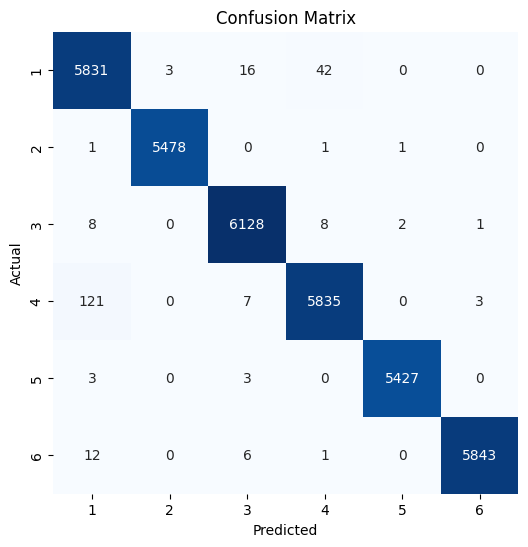

In [9]:

# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate(
    (y_test, y_pred)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_1178206/359193914.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importance.values,


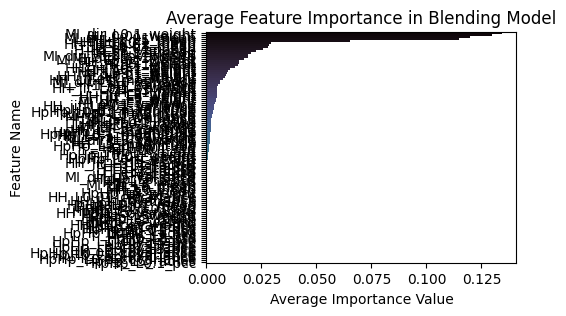

In [10]:

# Extract feature importances from base models
base_models_importances = {}

for i, model in enumerate([model1, model2, model3, model4]):
    if hasattr(model, 'feature_importances_'):
        base_models_importances[f'base_model_{i}'] = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame(base_models_importances, index=X.columns)

# Calculate average feature importance across base models
average_importance = importance_df.mean(axis=1)

# Sort features by average importance
sorted_importance = average_importance.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(4, 3))
sns.barplot(x=sorted_importance.values,
            y=sorted_importance.index, palette='mako')
plt.xlabel('Average Importance Value')
plt.ylabel('Feature Name')
plt.title('Average Feature Importance in Blending Model')
plt.show()